In [ ]:
import pandas as pd
import librosa
import numpy as np
from numpy.random import choice
import scipy
import pickle
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Adjust these paths as needed after checking your unzipped files
AUDIO_ROOT = '/content/gdrive/MyDrive/ECE6254 Proj/AUDIO'  # Adjust if folder name is different
MFCC_ROOT = '/content/gdrive/MyDrive/ECE6254 Proj/MFCC'

datasets = ['cv-valid-train', 'cv-valid-dev', 'cv-valid-test']
df_combined = []

for dataset in datasets:
    csv_file = f'{dataset}.csv'
    dftrain = pd.read_csv(csv_file)
    if (dataset == 'cv-valid-train'):
        dftrain = dftrain[dftrain['filename'] <= "cv-valid-train/sample-018122.mp3"]

    # Drop rows with missing gender
    dftrain = dftrain.dropna(subset=['gender'])

    # Drop rows with missing age
    dftrain = dftrain.dropna(subset=['age'])
    valid_ages = ['teens', 'twenties', 'thirties', 'fourties', 'fifties', 'sixties']
    dftrain = dftrain[dftrain['age'].isin(valid_ages)]

    # Drop unused 'duration' column (100% NaN in some releases)
    if 'duration' in dftrain.columns:
        dftrain = dftrain.drop('duration', axis=1, errors='ignore')

    # Drop rows with missing accent
    dftrain = dftrain.dropna(subset=['accent'])
    valid_accents = ['england', 'indian', 'australia', 'scotland', 'us', 'ireland']
    dftrain = dftrain[dftrain['accent'].isin(valid_accents)]
    for index, row in dftrain.iterrows():
        if row['age'] in ['teen', 'twenties']:
            dftrain.at[index, 'age'] = 'youth'
        elif row['age'] in ['thirties', 'forties']:
            dftrain.at[index, 'age'] = 'adult'
        else:
            dftrain.at[index, 'age'] = 'middle-age'
    df_combined.append(dftrain)

dftrain = pd.concat(df_combined, ignore_index=True)
print(dftrain.value_counts('age'))
print(len(dftrain))

age
middle-age    3262
youth         2138
adult         1783
Name: count, dtype: int64
7183


In [ ]:
def drop_random_samples(df, age, n):
    indices = df[df['age'] == age].index
    drop_indices = choice(indices, size=n, replace=False)
    return df.drop(drop_indices)

age_counts = dftrain['age'].value_counts()
min_count = age_counts.values.min()
for age in age_counts.index:
    current_count = age_counts[age]
    if current_count > min_count:
        dftrain = drop_random_samples(dftrain, age, current_count - min_count)

In [ ]:
label_encoder = LabelEncoder()
dftrain['age_encoded'] = label_encoder.fit_transform(dftrain['age'])
print(dftrain['age_encoded'].value_counts())
print(label_encoder.classes_)

age_encoded
2    1783
0    1783
1    1783
Name: count, dtype: int64
['adult' 'middle-age' 'youth']


In [7]:
dftrain.to_csv('age.csv', index=False)

In [ ]:
all_features = []
for index, row in dftrain.iterrows():
    features = np.array([])
    dataset = row['filename'].split('/')[0]
    file_path = os.path.join(dataset, row['filename'])
    print(f"Processing {file_path}")
    try:
        audio, sr = librosa.load(file_path, sr=None)
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
    # RMS Energy
    features = np.append(features, [np.mean(librosa.feature.rms(y=audio)[0])])
    # Zero-Crossing Rate
    features = np.append(features, [np.mean(librosa.feature.zero_crossing_rate(y=audio))])
    # Tempo
    features = np.append(features, [librosa.feature.tempo(y=audio, sr=sr)[0]])
    # Spectral Features
    spec_centroid = np.mean(librosa.feature.spectral_centroid(y=audio, sr=sr)[0])
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=audio, sr=sr)[0])
    spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=audio, sr=sr)[0])
    spectral_flatness = np.mean(librosa.feature.spectral_flatness(y=audio)[0])
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=audio, sr=sr)[0])
    features = np.append(features, [spec_centroid, spectral_bandwidth, spectral_contrast, spectral_flatness, spectral_rolloff])
    # Fundamental Frequency
    f0, voiced_flag, voiced_probs = librosa.pyin(audio, sr=sr, fmin=50, fmax=1000)
    voiced_f0 = f0[~np.isnan(f0)]
    mean_f0 = np.mean(voiced_f0) if len(voiced_f0) > 0 else 0
    features = np.append(features, [mean_f0])
    all_features.append(features)

In [ ]:
with open("all_features", "wb") as f:
    pickle.dump(all_features, f)

In [ ]:
all_mfccs = []
for index, row in dftrain.iterrows():
    dataset = row['filename'].split('/')[0]
    file_path = os.path.join(dataset, row['filename'])
    print(f"Processing {file_path}")
    y, sr = librosa.load(file_path, sr=None)

    # Define MFCC extraction parameters:
    # 25 ms window length, 10 ms hop length, Hann window, n_mfcc=20
    n_fft = int(sr * 0.025)      # 25 ms in samples
    hop_length = int(sr * 0.010)   # 10 ms in samples

    # Compute MFCC spectrogram
    mfcc = librosa.feature.mfcc(
        y=y,
        sr=sr,
        n_mfcc=20,
        n_fft=n_fft,
        win_length=n_fft,
        hop_length=hop_length,
        window='hann'
    )
    all_mfccs.append(mfcc)

In [21]:
mfcc_len = []
for mfcc in all_mfccs:
    mfcc_len.append(mfcc.shape[1])
median_len = np.median(mfcc_len)
padded_mfccs = []
for mfcc in all_mfccs:
  if mfcc.shape[1] < median_len:
    pad_width = int(median_len - mfcc.shape[1])
    padded_mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
  else:
    padded_mfcc = mfcc[:, :int(median_len)]
  padded_mfccs.append(padded_mfcc)

In [25]:
with open("all_mfccs", "wb") as f:
    pickle.dump(all_mfccs, f)
with open("padded_mfccs", "wb") as f:
    pickle.dump(padded_mfccs, f)

In [ ]:
mfcc_stats = []

for i in range(len(all_mfccs)):
    stats = []
    mfcc_data = all_mfccs[i]
    if (i % 100) == 0:
        print(f"Processing {i}th mfcc")
    for j in range(mfcc_data.shape[0]):
        x = mfcc_data[j, :]
        mean = np.mean(x)
        std = np.std(x)
        maxv = np.amax(x)
        minv = np.amin(x)
        median = np.median(x)
        skew = scipy.stats.skew(x)
        kurt = scipy.stats.kurtosis(x)
        q1 = np.quantile(x, 0.25)
        q3 = np.quantile(x, 0.75)
        iqr = scipy.stats.iqr(x)
        stats.extend([mean, std, maxv, minv, median, skew, kurt, q1, q3, iqr])
    mfcc_stats.append(stats)

In [28]:
with open("mfcc_stats", "wb") as f:
    pickle.dump(mfcc_stats, f)

In [ ]:
X = np.concatenate((all_features, mfcc_stats), axis=1)
y = dftrain['age_encoded'].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

selector = SelectKBest(score_func=f_classif, k=50)
X_train_selected = selector.fit_transform(X_train, y_train)

X_test_selected = selector.transform(X_test)

selected_feature_indices = selector.get_support(indices=True)

In [ ]:
scaler = StandardScaler()
X_train_sel_scaled = scaler.fit_transform(X_train_selected)
X_val_sel_scaled = scaler.transform(X_test_selected)

In [ ]:
svm_params = {
    'C': np.logspace(-3, 3, 10),
    'gamma': np.logspace(-4, 1, 10)
}
svm = GridSearchCV(SVC(kernel='rbf'), svm_params, cv=5, n_jobs=-1)
svm.fit(X_train_sel_scaled, y_train)

In [63]:
best_svm_rbf_model = svm.best_estimator_
print(f"Best RBF SVM Parameters: {svm.best_params_}")

Best RBF SVM Parameters: {'C': np.float64(2.154434690031882), 'gamma': np.float64(0.05994842503189409)}


In [ ]:
sigmoid_params = {
    'C': np.logspace(-3, 3, 10),
    'gamma': np.logspace(-3, 3, 10),
    'coef0': np.logspace(-3, 3, 10)
}
svm_sigmoid = SVC(kernel='sigmoid', random_state=42)
sigmoid_grid_search = GridSearchCV(estimator=svm_sigmoid, param_grid=sigmoid_params, cv=5, n_jobs=-1, scoring='accuracy')
sigmoid_grid_search.fit(X_train_sel_scaled, y_train)

In [ ]:
logreg_params = {
    'C': np.logspace(-3, 3, 10)
}
logreg = GridSearchCV(LogisticRegression(max_iter=1000), logreg_params, cv=5, n_jobs=-1)
logreg.fit(X_train_sel_scaled, y_train)
y_train_pred = logreg.predict(X_train_sel_scaled)

In [ ]:
nb = GaussianNB()
nb.fit(X_train_selected, y_train)
y_train_pred = nb.predict(X_train_selected)

In [ ]:
dt_params = {
    'max_depth': [None, 5, 10, 20, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

dt = DecisionTreeClassifier(random_state=42)

dt_grid_search = GridSearchCV(estimator=dt, param_grid=dt_params, cv=5, n_jobs=-1, scoring='accuracy')
dt_grid_search.fit(X_train_sel_scaled, y_train)

best_dt_model = dt_grid_search.best_estimator_
print(f"Best Decision Tree Parameters: {dt_grid_search.best_params_}")

In [ ]:
knn_params = {
    'n_neighbors': [3, 5, 7, 10, 15, 20],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

knn = KNeighborsClassifier()

knn_grid_search = GridSearchCV(estimator=knn, param_grid=knn_params, cv=5, n_jobs=-1, scoring='accuracy')
knn_grid_search.fit(X_train_sel_scaled, y_train)

# --- Step 4: Hyperparameter Search for Random Forest ---
rf_params = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

In [ ]:
# Initialize the Random Forest model
rf = RandomForestClassifier(random_state=42)

# Perform GridSearchCV with 5-fold cross-validation
rf_grid_search = GridSearchCV(estimator=rf, param_grid=rf_params, cv=5, n_jobs=-1, scoring='accuracy')
rf_grid_search.fit(X_train_sel_scaled, y_train)

In [ ]:
X_test_sel_scaled = scaler.transform(X_test_selected)
y_test_pred = svm.predict(X_test_sel_scaled)
test_acc = accuracy_score(y_test, y_test_pred)
conf_matrix = confusion_matrix(y_test, y_test_pred)
report = classification_report(y_test, y_test_pred)

print("\nSVM Performance on Test Set")
print(f"Test Accuracy: {test_acc:.4f}")
print("\nClassification Report:")
print(report)
print("Confusion Matrix:")
print(conf_matrix)


SVM Performance on Test Set
Test Accuracy: 0.6636

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.64      0.67       380
           1       0.60      0.71      0.65       324
           2       0.69      0.65      0.67       366

    accuracy                           0.66      1070
   macro avg       0.67      0.67      0.66      1070
weighted avg       0.67      0.66      0.66      1070

Confusion Matrix:
[[242  82  56]
 [ 44 230  50]
 [ 59  69 238]]


              precision    recall  f1-score   support

       adult       0.70      0.64      0.67       380
  middle-age       0.60      0.71      0.65       324
       youth       0.69      0.65      0.67       366

    accuracy                           0.66      1070
   macro avg       0.67      0.67      0.66      1070
weighted avg       0.67      0.66      0.66      1070



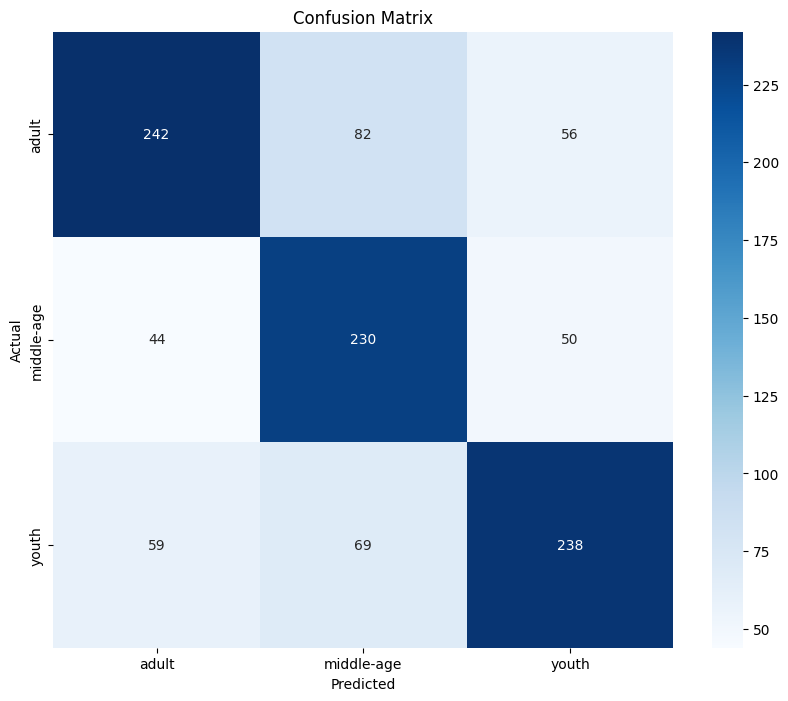

In [ ]:
print(classification_report(
    y_test,
    y_test_pred,
    target_names=label_encoder.classes_
))

cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
svm_pipeline = Pipeline([
    ('selector', selector), 
    ('scaler', scaler),
    ('svm', svm.best_estimator_)
])

joblib.dump(svm_pipeline, 'svm_rbf_pipeline.joblib')


['svm_rbf_pipeline.joblib']